In [132]:
import pymysql,sys,json
import seaborn as sns
import collections
import matplotlib.pyplot as plt
from dateutil import parser
import datetime
import numpy as np
from scipy.stats import pearsonr
%matplotlib inline
import pandas as pd

In [2]:
sns.set_style('white')
sns.despine()
sns.set_context("notebook", font_scale=2.0, rc={"lines.linewidth": 2.5})

In [3]:
conn = pymysql.connect(host='localhost',user='root',passwd='pulsetini', db='nairaland',charset='utf8')
cur = conn.cursor()
cur2 = conn.cursor()

###### Get users

In [4]:
df=pd.read_sql_query('select * from users',conn)
df2=pd.read_sql_query('select * from users_new_test',conn)
followingDf=pd.read_sql_query('select * from following',conn)
followingNewDf=pd.read_sql_query('select * from following_new',conn)

In [5]:
dfComb=pd.concat([df,df2])

In [6]:
df.head()

,userName,registered,gender,location,personal,lastSeen,timeSpent,posts,country,postition,lat,lon,divisionIndex,comments,postsInDb,updated
0,lildonne,"June 12, 2012",m,,"Am DONNE, the tymlezz entz. Rep. yung donne t...",4:09pm On Feb 03,1 day & 16 hours,71,None,None,NaN,NaN,None,12,4,None
1,dejt4u,"June 29, 2009",m,Planet earth_Dun'ya,,9:26pm On Feb 08,1 month & 6 days,4,None,None,NaN,NaN,None,657,15,None
2,macpetrus,"July 03, 2014",m,kepler-10c,,6:55am,15 days,567,None,None,NaN,NaN,None,450,1,None
3,disloman,"October 17, 2012",m,lagos,I'm a gee,4:35am,25 days & 9 hours,943,NG,None,6.53774,3.3522,05,590,7,None
4,idrismusty97,"December 05, 2012",m,Arewa Republic,"""When one person suffers from a delusion, it ...",7:18pm On Feb 08,2 months & 23 days,97,NG,None,7.38333,4.4500,00,1686,27,None


In [16]:
collections.Counter(df[df.country=='NG'].location.apply(unicode.lower).values).most_common(20)

[(u' nigeria', 4394),
 (u' lagos', 4295),
 (u' abuja', 1227),
 (u' lagos, nigeria', 610),
 (u' ibadan', 509),
 (u' port harcourt', 393),
 (u' enugu', 265),
 (u' lagos nigeria', 245),
 (u' kaduna', 219),
 (u' lagos,nigeria', 216),
 (u' ilorin', 169),
 (u' lagos ', 167),
 (u' owerri', 153),
 (u' benin city', 151),
 (u' warri', 132),
 (u' calabar', 130),
 (u' anambra', 118),
 (u' abuja, nigeria', 113),
 (u' akure', 113),
 (u' delta', 111)]

###### Make user network, both active users and inactive users

In [4]:
dfActive=pd.read_sql_query('select * from following',conn)

In [5]:
dfActive.head()

,source,target,sourceGender,targetGender
0,seun,Deefuray,None,None
1,seun,CAPTIVATOR,None,None
2,seun,TheAdvocate,None,None
3,seun,Naijasinglegirl,None,None
4,seun,lurther,None,None


In [8]:
from igraph import *

In [24]:
g=Graph()

In [25]:
g.add_vertices(set(df2.source).union(set(df2.target)))

In [30]:
print g.vs()['name']

MemoryError: 

In [ ]:
g.add_edges([(r[1].source,r[1].target) for r in df2.iterrows()])

In [23]:
g=df[df.userName=='seun'].gender

###### Assign Genders

In [ ]:
df=pd.read_sql_query("select userName from users where userName='TheTownPlanner'",conn)

###### Calculate gender conenctions

In [7]:
#nMale,nFemale,nNeither=sum(df.gender==u' m'),sum(df.gender==u' f'),sum(df.gender==u'')
#nMale,nFemale,nNeither=sum(df2.gender==u' m'),sum(df2.gender==u' f'),sum(df2.gender==u'')
nMale,nFemale,nNeither=sum(dfComb.gender==u' m'),sum(dfComb.gender==u' f'),sum(dfComb.gender==u'')

###Expected Following Proportions

In [49]:
mf,mm,ff,mn,fn,nn=nMale*nFemale,nMale*nMale,nFemale*nFemale,nMale*nNeither,nFemale*nNeither,nNeither*nNeither
total=float(mf+mm+ff+mn+fn+nn)
print 'M,F,N',nMale,nFemale,nNeither
print 'M-F','%.3f' % (mf/total)
print 'M-N','%.3f' % (mn/total)
print 'F-N','%.3f' % (fn/total)
print 'N-N','%.3f' % (nn/total)
print 'M-M','%.3f' % (mm/total)
print 'F-F','%.3f' % (ff/total)

M,F,N 43006 15486 58351
M-F 0.070
M-N 0.262
F-N 0.094
N-N 0.356
M-M 0.193
F-F 0.025


In [9]:
userGender={}
for r in dfComb.iterrows():
    if not r[1][2]==u'':
        userGender[r[1][0]]=r[1][2]

In [10]:
followingDf['sourceGender']=None
followingNewDf['sourceGender']=None

In [11]:
followingDf['targetGender']=None
followingNewDf['targetGender']=None

In [12]:
followingDf['sourceGender']=followingDf['source'].apply(lambda u:userGender.get(u))
followingNewDf['sourceGender']=followingNewDf['source'].apply(lambda u:userGender.get(u))

In [13]:
followingDf['targetGender']=followingDf['target'].apply(lambda u:userGender.get(u))
followingNewDf['targetGender']=followingNewDf['target'].apply(lambda u:userGender.get(u))

In [15]:
d=followingDf[['sourceGender','targetGender']]

In [16]:
collections.Counter(d.targetGender).most_common()

[(None, 191410), (u' f', 81131), (u' m', 75958)]

In [17]:
dyads=collections.Counter(zip(d.sourceGender.values,d.targetGender.values))

In [19]:
dyadsSum=sum(dyads.values())

In [92]:
for k in [(u' m',None),(None,u' m')]:
    print k,dyads[k]

for k in [(u' f',None),(None,u' f')]:
    print k,dyads[k]


(u' m', None) 117068
(None, u' m') 13736
(u' f', None) 35483
(None, u' f') 14427


In [99]:
for k1,k2 in ([(u' m',u' f'),(u' m',None),(u' f',None)]):
    print k1,k2,':',dyads[(k1,k2)],k2,k1,':',dyads[(k2,k1)],'%.3f' % (dyads[(k1,k2)]/float(dyads[(k2,k1)]))

 m  f : 61088  f  m : 25255 2.419
 m None : 117068 None  m : 13736 8.523
 f None : 35483 None  f : 14427 2.459


###Actual Following Proportions

In [44]:
print 'm,f','%0.3f' % ((dyads[(u' m',u' f')]+dyads[(u' f',u' m')])/float(dyadsSum))
print 'm,None','%0.3f' % ((dyads[(u' m',None)]+dyads[(None,u' m')])/float(dyadsSum))
print 'f,None','%0.3f' % ((dyads[(u' f',None)]+dyads[(None,u' f')])/float(dyadsSum))
print 'None,None','%0.3f' % ((dyads[(None,None)])/float(dyadsSum))
print 'm,m','%0.3f' % ((dyads[(u' m',u' m')])/float(dyadsSum))
print 'f,f','%0.3f' % ((dyads[(u' f',u' f')])/float(dyadsSum))

m,f 0.248
m,None 0.375
f,None 0.143
None,None 0.112
m,m 0.106
f,f 0.016


In [22]:
for k,v in dyads.most_common():
    print k,'%.3f' % (v/float(dyadsSum)),v

(u' m', None) 0.336 117068
(u' m', u' f') 0.175 61088
(None, None) 0.112 38859
(u' m', u' m') 0.106 36967
(u' f', None) 0.102 35483
(u' f', u' m') 0.072 25255
(None, u' f') 0.041 14427
(None, u' m') 0.039 13736
(u' f', u' f') 0.016 5616


In [86]:
g=df2[df2['sourceGender']=='m'].groupby('source')

In [88]:
g.count()

,target,sourceGender,targetGender
source,,,


In [118]:
g=df2.where(df2['sourceGender']=='m').groupby('source')

In [26]:
cur.execute('select source,count(*) from following group by source')

26246

In [33]:
df2.iterrows().next()[1].source

u'seun'

###### Write out graph for D3

In [37]:
out={}
out['directed']=True
out['multigraph']=False
out['nodes']=[{"id":r[0],"degree":r[1]} for r in cur]
out['links']=[{"source":r[1].source,"target":r[1].target,"weight":1} for r in df2.iterrows()]
with open('follow_graph.txt','w') as outFile:
    outFile.write(json.dumps(out)+'\n')

In [ ]:
cur.execute("select a.source,a.target,b.gender sourceGender,c.gender targetGender from following a inner join users b on a.source=b.userName inner join users c on a.target=c.userName")

In [ ]:
followers=collections.defaultdict((int,int))

In [4]:
%time maleDf=pd.read_sql_query("select a.source,b.gender,count(*) from following a inner join users b on a.source=b.userName where b.gender like '%m%' group by a.source;",conn)

CPU times: user 556 ms, sys: 38.8 ms, total: 595 ms
Wall time: 23min 27s


In [5]:
%time femaleDf=pd.read_sql_query("select a.source,b.gender,count(*) from following a inner join users b on a.source=b.userName where b.gender like '%f%' group by a.source;",conn)

CPU times: user 128 ms, sys: 5.08 ms, total: 133 ms
Wall time: 5min 23s


###### Distribution of posts per user both active and inactive (over all time)

In [6]:
nPostsDf=pd.read_sql_query("select user,count(*) from posts2 where user <> '__MISSING__' group by user;",conn)
nPostsDf.columns=['user','counts']

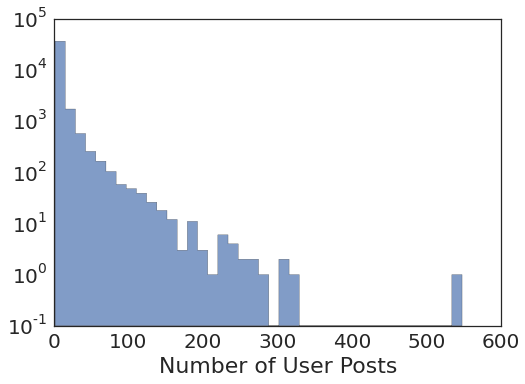

In [53]:
plt.hist(nPostsDf.counts,log=True,histtype="stepfilled",alpha=0.7,bins=40)
plt.xlabel('Number of User Posts')
#plt.ylim(1,10**5)
plt.savefig('user_post_dist.png',dpi=200)

###### Distribution of comments per user

In [19]:
nCommentsDf=pd.read_sql_query("select user,count(*) from comments where user <> '__MISSING__' group by user;",conn)
nCommentsDf.columns=['user','counts']

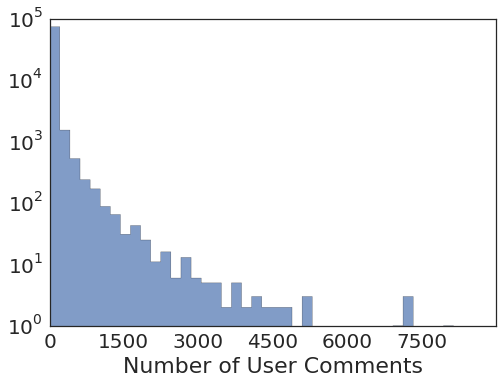

In [26]:
plt.hist(nCommentsDf.counts,log=True,histtype="stepfilled",alpha=0.7,bins=40)
plt.xlabel('Number of User Comments')
plt.ylim(1,10**5)
plt.xticks([i*1500 for i in range(6)])
plt.savefig('user_comment_dist.png',dpi=200)

###### Update DB for number of posts per user (in time range)

In [6]:
for r in nPostsDf.iterrows():
    cur.execute("update users set postsInDb="+str(r[1].counts)+" where userName='"+r[1].user+"'")
    cur.connection.commit()

###### Ditribution os posts and comments over time period for users

In [7]:
%time userActivity=pd.read_sql_query("select userName,comments,postsInDb from users where userName <> '__missing__'",conn)

CPU times: user 4.66 s, sys: 0 ns, total: 4.66 s
Wall time: 4.57 s


In [10]:
userActivity.columns=['user','comments','posts']

In [11]:
userActivityNonZero=userActivity[(userActivity.comments>0)&(userActivity.posts>1)&(userActivity.posts<100000)]

In [12]:
userActivity[0:10]

,user,comments,posts
0,lildonne,12,4
1,dejt4u,657,15
2,macpetrus,450,1
3,disloman,590,7
4,idrismusty97,1686,27
5,elueme,0,0
6,chimanet,13,0
7,seun,1009,42
8,codehouse,223,9
9,slye,95,5


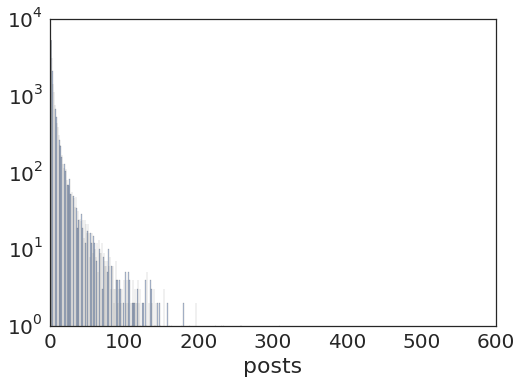

In [14]:
sns.distplot(userActivityNonZero[0:].posts,hist_kws={'log':True},kde=False)

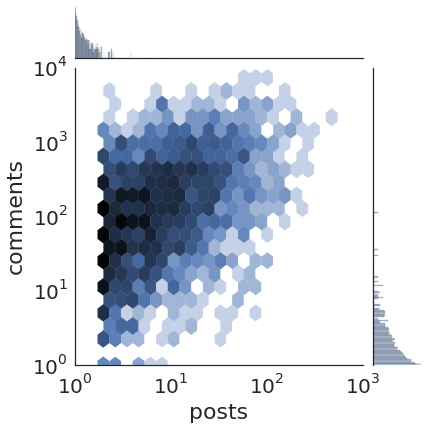

In [16]:
j=sns.jointplot(userActivityNonZero[0:3000].posts,userActivityNonZero[0:3000].comments,kind='hex',
marginal_kws={'hist_kws':{'log':True}},
stat_func=None,joint_kws={'yscale':'log','xscale':'log','bins':'log','gridsize':20}
)
plt.savefig('user_comment_post_dist.png',dpi=200)

In [ ]:
sns.jointplot(userActivityNonZero[0:3000].posts,userActivityNonZero[0:3000].comments,kind='hex',
joint_kws={'bins':'log','xscale':'log','yscale':'log'},stat_func=None,
xlim=(1,1000000),marginal_kws={'hist_kws': {'gridsize':10}})

In [4]:
%time signupActivity=pd.read_sql_query("select registered from users where userName <> '__missing__'",conn)

CPU times: user 1.58 s, sys: 12.6 ms, total: 1.59 s
Wall time: 1.58 s


In [5]:
signupActivity.index=pd.to_datetime(signupActivity['registered'])

In [6]:
def mjrFormatter(x, pos):
    return '%.2f%%'.format(x)

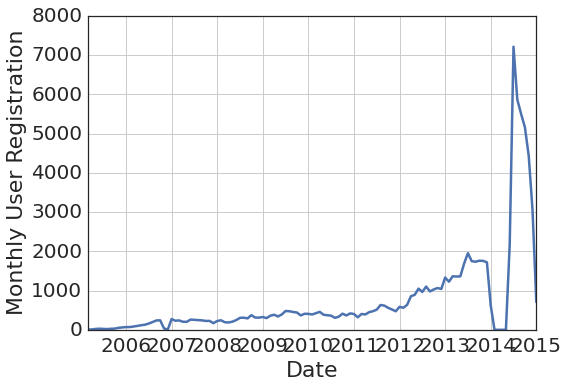

In [14]:
import matplotlib as mpl
import datetime
fig,ax=plt.subplots()
signupActivity.resample('M',how='count')['registered'].plot()
#ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2e'))
#plt.xlim(datetime.datetime(2009,1,1),datetime.datetime(2015,1,1))
plt.xlabel('Date')
plt.ylabel('Monthly User Registration')
plt.tight_layout()
plt.savefig('user_registrations_all.png',dpi=200)

###Compare Sign up of Male Users

In [120]:
maleRegistered=dfComb[dfComb['gender']==u' m']['registered']
maleRegistered.index=maleRegistered.apply(pd.to_datetime)
maleRegisteredDf=pd.DataFrame(index=maleRegistered.index,data={'dummy':1})

In [122]:
femaleRegistered=dfComb[dfComb['gender']==u' f']['registered']
femaleRegistered.index=femaleRegistered.apply(pd.to_datetime)
femaleRegisteredDf=pd.DataFrame(index=femaleRegistered.index,data={'dummy':1})

In [145]:
maleRegisteredDf.resample('2w',how='count')['dummy'].shape

(261,)

In [153]:
maleRegisteredDf.resample('2w',how='count').index[230]

Timestamp('2014-01-05 00:00:00', offset='2W-SUN')

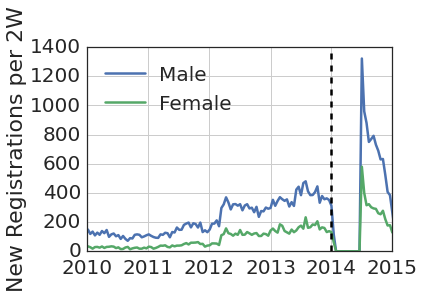

In [160]:
maleRegisteredDf.resample('2w',how='count')['dummy'].plot(label='t')
femaleRegisteredDf.resample('2w',how='count')['dummy'].plot()
plt.xlim(datetime.datetime(2010,1,1),datetime.datetime(2015,1,1))
plt.legend(['Male','Female'],loc='upper left')
plt.xlabel('')
plt.ylabel('New Registrations per 2W')
plt.axvline(maleRegisteredDf.resample('2w',how='count').index[230],color='k',linestyle='--')
plt.tight_layout()
plt.savefig('registrations_time_series_gender.png',dpi=200)

In [118]:
datetime.datetime(2005,1,1)

datetime.datetime(2005, 1, 1, 0, 0)

In [161]:
pearsonr(maleRegisteredDf.resample('2w',how='count')['dummy'][0:230],femaleRegisteredDf.resample('2w',how='count')['dummy'][0:230])

(0.96090897908729089, 3.7721124755865593e-129)